<a href="https://colab.research.google.com/github/savcooley/full_waveform_lidar_training/blob/main/gedi_l1b_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# GEDI L1B Data Processing Script for Google Colab
# Author: Your Name
# Repository: https://github.com/savcooley/full_waveform_lidar_training.git

# Install required packages
!pip install earthaccess h5py geopandas matplotlib seaborn requests shapely folium
!pip install --upgrade earthaccess

# Import libraries
import os
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import folium
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
import earthaccess

print("All libraries imported successfully!")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 104.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.9.0 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
All libraries imported successfully!


In [ ]:
# Authenticate with NASA Earthdata
auth = earthaccess.login()

if auth.authenticated:
    print("✓ Successfully authenticated with NASA Earthdata!")
else:
    print("✗ Authentication failed. Please check your credentials.")

# Define your Area of Interest (AOI)
# Example: William Bankhead National Forest and surrounding area near Double Springs, AL
aoi_bbox = [-87.41, 34.2, -87.35, 34.24]  # [min_lon, min_lat, max_lon, max_lat]

print(f"Area of Interest (Bounding Box): {aoi_bbox}")
print(f"Longitude range: {aoi_bbox[0]} to {aoi_bbox[2]}")
print(f"Latitude range: {aoi_bbox[1]} to {aoi_bbox[3]}")

# Define temporal range
start_date = "2019-04-01"
end_date = "2024-12-31"

print(f"Temporal range: {start_date} to {end_date}")

# Define Full Power beams only
FULL_POWER_BEAMS = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
print(f"Processing Full Power beams only: {FULL_POWER_BEAMS}")

# Search for GEDI L1B granules - FIXED VERSION
def search_gedi_l1b(bbox, start_date, end_date, max_results=20):
    """
    Search for GEDI L1B granules - Fixed for newer earthaccess versions
    Increased max_results to have more options if files don't contain quality data

    Parameters:
    bbox: list of [min_lon, min_lat, max_lon, max_lat]
    """
    print(f"Searching for GEDI L1B data...")
    print(f"  Bounding box: {bbox}")
    print(f"  Date range: {start_date} to {end_date}")
    print(f"  Max results: {max_results}")

    # FIXED: Pass bounding box coordinates as separate arguments
    min_lon, min_lat, max_lon, max_lat = bbox

    try:
        results = earthaccess.search_data(
            short_name="GEDI01_B",
            version="002",
            bounding_box=(min_lon, min_lat, max_lon, max_lat),  # As tuple with 4 values
            temporal=(start_date, end_date),
            count=max_results
        )

        print(f"Found {len(results)} GEDI L1B granules")
        return results

    except Exception as e:
        print(f"Error in search: {str(e)}")
        print("Trying alternative bounding box format...")

        # Alternative format if the above doesn't work
        try:
            results = earthaccess.search_data(
                short_name="GEDI01_B",
                version="002",
                bounding_box=f"{min_lon},{min_lat},{max_lon},{max_lat}",  # As string
                temporal=(start_date, end_date),
                count=max_results
            )

            print(f"Found {len(results)} GEDI L1B granules")
            return results

        except Exception as e2:
            print(f"Second attempt failed: {str(e2)}")
            print("Trying without bounding box (will filter spatially later)...")

            # Last resort: search without spatial filter
            try:
                results = earthaccess.search_data(
                    short_name="GEDI01_B",
                    version="002",
                    temporal=(start_date, end_date),
                    count=max_results * 2  # Get more results to filter later
                )

                print(f"Found {len(results)} GEDI L1B granules (will filter spatially)")
                return results

            except Exception as e3:
                print(f"All search attempts failed: {str(e3)}")
                return []

# Extract and process data - Full Power beams only
def extract_gedi_l1b_data(file_path, aoi_bbox, full_power_beams_only=True):
    """Extract GEDI L1B data with spatial filtering - Full Power beams only"""
    extracted_data = {}

    print(f"\nOpening GEDI file: {os.path.basename(file_path)}")

    try:
        with h5py.File(file_path, 'r') as gedi_file:
            # Get all beam names
            all_beam_names = [key for key in gedi_file.keys() if key.startswith('BEAM')]

            # Filter to Full Power beams only
            if full_power_beams_only:
                beam_names = [beam for beam in all_beam_names if beam in FULL_POWER_BEAMS]
                print(f"Available beams: {all_beam_names}")
                print(f"Full Power beams found: {beam_names}")
            else:
                beam_names = all_beam_names
                print(f"Available beams: {beam_names}")

            if not beam_names:
                print("❌ No Full Power beams found in this file!")
                return {}

            for beam in beam_names:
                try:
                    print(f"\n  Processing {beam}...")

                    # Check if required datasets exist
                    required_datasets = [
                        f'{beam}/geolocation/latitude_bin0',
                        f'{beam}/geolocation/longitude_bin0',
                        f'{beam}/shot_number',
                        f'{beam}/geolocation/degrade',
                        f'{beam}/stale_return_flag',
                        f'{beam}/geolocation/elevation_bin0'
                    ]

                    missing_datasets = [ds for ds in required_datasets if ds not in gedi_file]
                    if missing_datasets:
                        print(f"    ⚠️ Missing datasets: {missing_datasets}")
                        continue

                    # Extract coordinate data
                    lat = gedi_file[f'{beam}/geolocation/latitude_bin0'][:]
                    lon = gedi_file[f'{beam}/geolocation/longitude_bin0'][:]
                    shot_number = gedi_file[f'{beam}/shot_number'][:]
                    degrade_flag = gedi_file[f'{beam}/geolocation/degrade'][:]
                    stale_return_flag = gedi_file[f'{beam}/stale_return_flag'][:]
                    elev_bin0 = gedi_file[f'{beam}/geolocation/elevation_bin0'][:]

                    print(f"    Total shots in beam: {len(lat)}")

                    # Apply spatial filter
                    spatial_mask = (
                        (lon >= aoi_bbox[0]) & (lon <= aoi_bbox[2]) &
                        (lat >= aoi_bbox[1]) & (lat <= aoi_bbox[3])
                    )

                    spatial_shots = np.sum(spatial_mask)
                    print(f"    Shots in AOI: {spatial_shots}")

                    if spatial_shots > 0:
                        extracted_data[beam] = {
                            'latitude': lat[spatial_mask],
                            'longitude': lon[spatial_mask],
                            'shot_number': shot_number[spatial_mask],
                            'degrade_flag': degrade_flag[spatial_mask],
                            'stale_return_flag': stale_return_flag[spatial_mask],
                            'elevation_bin0': elev_bin0[spatial_mask]
                        }
                        print(f"    ✓ Extracted {spatial_shots} shots from {beam}")
                    else:
                        print(f"    ✗ No shots found in AOI for {beam}")

                except Exception as e:
                    print(f"    ❌ Error processing {beam}: {str(e)}")
                    continue

        return extracted_data

    except Exception as e:
        print(f"❌ Error opening file: {str(e)}")
        return {}

# Apply quality filtering with detailed reporting
def apply_quality_filters(gedi_data, verbose=True):
    """Apply standard GEDI quality filters with detailed reporting"""
    if verbose:
        print(f"\nApplying quality filters...")
        print("  Criteria: degrade_flag = 0, stale_return_flag = 0")

    filtered_data = {}
    total_before = 0
    total_after = 0

    for beam, data in gedi_data.items():
        if len(data['shot_number']) == 0:
            continue

        # Apply quality filters
        quality_mask = (
            (data['degrade_flag'] == 0) &
            (data['stale_return_flag'] == 0)
        )

        shots_before = len(data['shot_number'])
        shots_after = np.sum(quality_mask)
        retention_rate = (shots_after / shots_before * 100) if shots_before > 0 else 0

        total_before += shots_before
        total_after += shots_after

        if verbose:
            print(f"  {beam}: {shots_before} → {shots_after} shots ({retention_rate:.1f}% retained)")

        if shots_after > 0:
            filtered_data[beam] = {
                'latitude': data['latitude'][quality_mask],
                'longitude': data['longitude'][quality_mask],
                'shot_number': data['shot_number'][quality_mask],
                'elevation_bin0': data['elevation_bin0'][quality_mask],
                'degrade_flag': data['degrade_flag'][quality_mask],
                'stale_return_flag': data['stale_return_flag'][quality_mask]
            }

    overall_retention = (total_after / total_before * 100) if total_before > 0 else 0

    if verbose:
        print(f"\nOverall: {total_before} → {total_after} shots ({overall_retention:.1f}% retained)")

    return filtered_data, overall_retention, total_after

def delete_file_safely(file_path):
    """Safely delete a file with confirmation"""
    try:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"🗑️ Deleted file: {os.path.basename(file_path)}")
            return True
        else:
            print(f"⚠️ File not found for deletion: {file_path}")
            return False
    except Exception as e:
        print(f"❌ Error deleting file {file_path}: {str(e)}")
        return False

def process_gedi_granules_with_retry(gedi_granules, aoi_bbox, max_attempts=5):
    """
    Process GEDI granules with automatic retry if no quality data is found

    Parameters:
    gedi_granules: list of granules from earthaccess search
    aoi_bbox: area of interest bounding box
    max_attempts: maximum number of files to try

    Returns:
    tuple: (success, result_df, processed_file_info)
    """

    download_dir = "./gedi_data"
    os.makedirs(download_dir, exist_ok=True)

    attempts = 0
    processed_files = []

    for i, granule in enumerate(gedi_granules):
        if attempts >= max_attempts:
            print(f"\n⚠️ Reached maximum attempts ({max_attempts}). Stopping.")
            break

        attempts += 1

        try:
            granule_id = granule['umm']['GranuleUR']
        except:
            granule_id = f"Granule_{i+1}"

        print(f"\n{'='*80}")
        print(f"ATTEMPT {attempts}/{max_attempts}: Processing {granule_id}")
        print(f"{'='*80}")

        # Download the granule
        print(f"📥 Downloading granule...")
        try:
            downloaded_files = earthaccess.download(
                [granule],  # Download single granule
                local_path=download_dir
            )

            if not downloaded_files:
                print(f"❌ Download failed for {granule_id}")
                continue

            sample_file = downloaded_files[0]
            file_size = os.path.getsize(sample_file) / 1e9
            print(f"✓ Downloaded: {os.path.basename(sample_file)} ({file_size:.2f} GB)")

        except Exception as e:
            print(f"❌ Download error for {granule_id}: {str(e)}")
            continue

        # Process the file
        print(f"\n📊 Processing GEDI L1B data...")

        # Extract data
        gedi_data = extract_gedi_l1b_data(sample_file, aoi_bbox, full_power_beams_only=True)

        if not gedi_data:
            print(f"❌ No spatial data found in AOI for {granule_id}")
            print(f"🗑️ Deleting file with no useful data...")
            delete_file_safely(sample_file)
            processed_files.append({
                'granule_id': granule_id,
                'file_name': os.path.basename(sample_file),
                'file_size_gb': file_size,
                'status': 'no_spatial_data',
                'shots_extracted': 0,
                'shots_after_qa': 0,
                'retention_rate': 0.0
            })
            continue

        # Apply quality filters
        filtered_gedi_data, retention_rate, shots_after_qa = apply_quality_filters(gedi_data, verbose=True)

        # Record processing info
        total_shots_extracted = sum(len(data['shot_number']) for data in gedi_data.values())
        processed_files.append({
            'granule_id': granule_id,
            'file_name': os.path.basename(sample_file),
            'file_size_gb': file_size,
            'status': 'processed',
            'shots_extracted': total_shots_extracted,
            'shots_after_qa': shots_after_qa,
            'retention_rate': retention_rate
        })

        # Check if we found quality data
        if shots_after_qa == 0:
            print(f"\n❌ No shots passed quality filtering for {granule_id}")
            print(f"🗑️ Deleting file with no quality data...")
            delete_file_safely(sample_file)
            processed_files[-1]['status'] = 'no_quality_data'

            if attempts < max_attempts:
                print(f"\n🔄 Trying next granule... ({attempts}/{max_attempts} attempts)")
            continue
        else:
            # Success! We found quality data
            print(f"\n🎉 SUCCESS! Found {shots_after_qa} high-quality shots in {granule_id}")

            # Create summary DataFrame
            print(f"\n📋 Creating summary DataFrame...")
            all_data = []

            for beam, data in filtered_gedi_data.items():
                beam_df = pd.DataFrame({
                    'granule_id': granule_id,
                    'beam': beam,
                    'shot_number': data['shot_number'],
                    'latitude': data['latitude'],
                    'longitude': data['longitude'],
                    'elevation_bin0': data['elevation_bin0'],
                    'degrade_flag': data['degrade_flag'],
                    'stale_return_flag': data['stale_return_flag']
                })
                all_data.append(beam_df)

            result_df = pd.concat(all_data, ignore_index=True)
            processed_files[-1]['status'] = 'success'

            return True, result_df, processed_files, sample_file

    # If we get here, no files had quality data
    print(f"\n❌ No granules contained quality data after {attempts} attempts")
    return False, None, processed_files, None

# Perform the search
print(f"\n🔍 Searching for GEDI L1B granules...")
gedi_granules = search_gedi_l1b(aoi_bbox, start_date, end_date, max_results=20)

if gedi_granules:
    print(f"\n📋 Found granules:")
    for i, granule in enumerate(gedi_granules[:5]):  # Show first 5
        try:
            granule_id = granule['umm']['GranuleUR']
            print(f"  {i+1}. {granule_id}")
        except:
            print(f"  {i+1}. Granule found (ID extraction failed)")

    if len(gedi_granules) > 5:
        print(f"  ... and {len(gedi_granules) - 5} more granules")

    # Process granules with automatic retry
    print(f"\n🚀 Starting processing with automatic retry...")
    success, result_df, processing_log, final_file = process_gedi_granules_with_retry(
        gedi_granules, aoi_bbox, max_attempts=5
    )

    # Display processing summary
    print(f"\n{'='*80}")
    print("PROCESSING SUMMARY")
    print(f"{'='*80}")

    processing_df = pd.DataFrame(processing_log)
    if not processing_df.empty:
        print(f"\nFiles processed:")
        for _, row in processing_df.iterrows():
            status_icon = {
                'success': '✅',
                'no_spatial_data': '🚫',
                'no_quality_data': '❌',
                'processed': '📊'
            }.get(row['status'], '❓')

            print(f"  {status_icon} {row['file_name']} ({row['file_size_gb']:.2f} GB)")
            print(f"      Status: {row['status']}")
            print(f"      Shots extracted: {row['shots_extracted']}")
            print(f"      Shots after QA: {row['shots_after_qa']}")
            print(f"      Retention rate: {row['retention_rate']:.1f}%")

    if success and result_df is not None:
        print(f"\n🎉 FINAL RESULTS:")
        print(f"  ✅ Successfully processed granule with quality data")
        print(f"  📊 Total high-quality shots: {len(result_df)}")
        print(f"  🎯 Full Power beams processed: {result_df['beam'].nunique()}")

        # Display sample data
        print(f"\n📋 Sample of processed data:")
        print(result_df.head(10))

        print(f"\n📈 Data summary:")
        print(f"  Beams processed: {result_df['beam'].nunique()}")
        print(f"  Shots per beam: {result_df.groupby('beam').size().to_dict()}")
        print(f"  Elevation range: {result_df['elevation_bin0'].min():.1f} to {result_df['elevation_bin0'].max():.1f} m")
        print(f"  Latitude range: {result_df['latitude'].min():.6f} to {result_df['latitude'].max():.6f}")
        print(f"  Longitude range: {result_df['longitude'].min():.6f} to {result_df['longitude'].max():.6f}")

        # Export results
        output_dir = "./gedi_L1B_outputs"
        os.makedirs(output_dir, exist_ok=True)

        # Export main results
        csv_path = os.path.join(output_dir, "gedi_l1b_quality_filtered_full_power.csv")
        result_df.to_csv(csv_path, index=False)
        print(f"\n💾 Results exported to: {csv_path}")

        # Export processing log
        log_path = os.path.join(output_dir, "processing_log.csv")
        processing_df.to_csv(log_path, index=False)
        print(f"💾 Processing log exported to: {log_path}")

        # Create visualization
        print(f"\n📊 Creating visualizations...")
        plt.figure(figsize=(16, 10))

        # Create subplot layout
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Shot locations colored by elevation
        scatter = ax1.scatter(result_df['longitude'], result_df['latitude'],
                            c=result_df['elevation_bin0'], cmap='terrain', s=30, alpha=0.7)
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_title('GEDI L1B High-Quality Shots (Full Power Beams)')
        ax1.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax1, label='Elevation (m)')

        # Plot 2: Elevation histogram
        ax2.hist(result_df['elevation_bin0'], bins=30, alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Elevation (m)')
        ax2.set_ylabel('Number of Shots')
        ax2.set_title('Elevation Distribution')
        ax2.grid(True, alpha=0.3)

        # Plot 3: Shots per beam
        beam_counts = result_df['beam'].value_counts()
        ax3.bar(beam_counts.index, beam_counts.values, alpha=0.7)
        ax3.set_xlabel('Beam')
        ax3.set_ylabel('Number of Shots')
        ax3.set_title('Shots per Full Power Beam')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

        # Plot 4: Processing attempts
        status_counts = processing_df['status'].value_counts()
        ax4.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
        ax4.set_title('Processing Results')

        plt.tight_layout()
        plt.show()

        # Create interactive map
        print(f"\n🗺️ Creating interactive map...")
        center_lat = result_df['latitude'].mean()
        center_lon = result_df['longitude'].mean()

        m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

        # Add AOI rectangle
        folium.Rectangle(
            bounds=[[aoi_bbox[1], aoi_bbox[0]], [aoi_bbox[3], aoi_bbox[2]]],
            fill=False,
            color='red',
            weight=3,
            popup='Area of Interest'
        ).add_to(m)

        # Color map for different beams
        beam_colors = {'BEAM0101': 'red', 'BEAM0110': 'blue', 'BEAM1000': 'green', 'BEAM1011': 'orange'}

        # Add points colored by beam
        for _, row in result_df.iterrows():
            color = beam_colors.get(row['beam'], 'gray')
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=4,
                popup=f"Beam: {row['beam']}<br>Shot: {row['shot_number']}<br>Elevation: {row['elevation_bin0']:.1f}m",
                color=color,
                fillColor=color,
                fillOpacity=0.7
            ).add_to(m)

        # Add legend
        legend_html = '''
        <div style="position: fixed;
                    bottom: 50px; left: 50px; width: 150px; height: 90px;
                    background-color: white; border:2px solid grey; z-index:9999;
                    font-size:14px; padding: 10px">
        <p><b>Full Power Beams</b></p>
        <p><i class="fa fa-circle" style="color:red"></i> BEAM0101</p>
        <p><i class="fa fa-circle" style="color:blue"></i> BEAM0110</p>
        <p><i class="fa fa-circle" style="color:green"></i> BEAM1000</p>
        <p><i class="fa fa-circle" style="color:orange"></i> BEAM1011</p>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))

        # Display map
        m

    else:
        print(f"\n❌ PROCESSING FAILED:")
        print(f"  No granules contained quality data in the AOI")
        print(f"  Files attempted: {len(processing_log)}")
        print(f"\n💡 Suggestions:")
        print(f"    - Expand your AOI bounding box")
        print(f"    - Try a different time period")
        print(f"    - Check if your AOI is in a valid GEDI coverage area (±51.6° latitude)")

else:
    print("❌ No granules found. Try expanding your search criteria.")

print(f"\n{'='*80}")
print("PROCESSING COMPLETE")
print(f"{'='*80}")
print("✅ Data search completed")
print("✅ Full Power beams processing only")
print("✅ Automatic retry for quality data")
print("✅ File cleanup for unusable data")
print("✅ Results exported")
print("\n🔧 Next steps:")
print("   - Modify aoi_bbox for your study area")
print("   - Adjust quality filtering criteria if needed")
print("   - Add waveform analysis functions")
print("   - Process additional granules if needed")
print("\n📁 Output files saved to: ./gedi_L1B_outputs/")

✓ Successfully authenticated with NASA Earthdata!
Area of Interest (Bounding Box): [-87.41, 34.2, -87.35, 34.24]
Longitude range: -87.41 to -87.35
Latitude range: 34.2 to 34.24
Temporal range: 2019-04-01 to 2024-12-31
Processing Full Power beams only: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

🔍 Searching for GEDI L1B granules...
Searching for GEDI L1B data...
  Bounding box: [-87.41, 34.2, -87.35, 34.24]
  Date range: 2019-04-01 to 2024-12-31
  Max results: 20
Found 20 GEDI L1B granules

📋 Found granules:
  1. GEDI01_B_2019111192847_O02018_03_T04473_02_005_01_V002
  2. GEDI01_B_2019230201557_O03866_03_T02897_02_005_01_V002
  3. GEDI01_B_2019263001316_O04365_02_T03688_02_005_01_V002
  4. GEDI01_B_2019298172214_O04919_03_T01627_02_005_01_V002
  5. GEDI01_B_2019338181324_O05540_02_T00842_02_005_01_V002
  ... and 15 more granules

🚀 Starting processing with automatic retry...

ATTEMPT 1/5: Processing GEDI01_B_2019111192847_O02018_03_T04473_02_005_01_V002
📥 Downloading granule...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]


WAVEFORM VISUALIZATION MODULE - SIMPLIFIED

🎯 WAVEFORM ANALYSIS READY!
Data available: 223 high-quality shots
Elevation_bin0 range: 232.6 to 305.8 m
Mean elevation_bin0: 266.07 ± 14.17 m

🔧 USER CONFIGURATION:
   Standard deviations from mean: +1.2
   This will select shots with elevation_bin0 ≈ 283.1 m
🎯 Target selection parameters:
   Mean elevation_bin0: 266.07 m
   Std elevation_bin0:  14.17 m
   Target elevation_bin0: 283.07 m (+1.2σ)
📋 Selected 5 shots:
   1. Shot 38660500300200568: elevation_bin0=282.95m, Lat=34.167388, Lon=-87.388429, Beam=BEAM0101
   2. Shot 38660800300205874: elevation_bin0=282.87m, Lat=34.151343, Lon=-87.391434, Beam=BEAM1000
   3. Shot 38661100300200679: elevation_bin0=283.39m, Lat=34.150185, Lon=-87.399376, Beam=BEAM1011
   4. Shot 38660800300205860: elevation_bin0=283.39m, Lat=34.156311, Lon=-87.397694, Beam=BEAM1000
   5. Shot 38660500300200579: elevation_bin0=283.81m, Lat=34.163482, Lon=-87.383498, Beam=BEAM0101

📊 Extracting waveforms from GEDI01_B_20

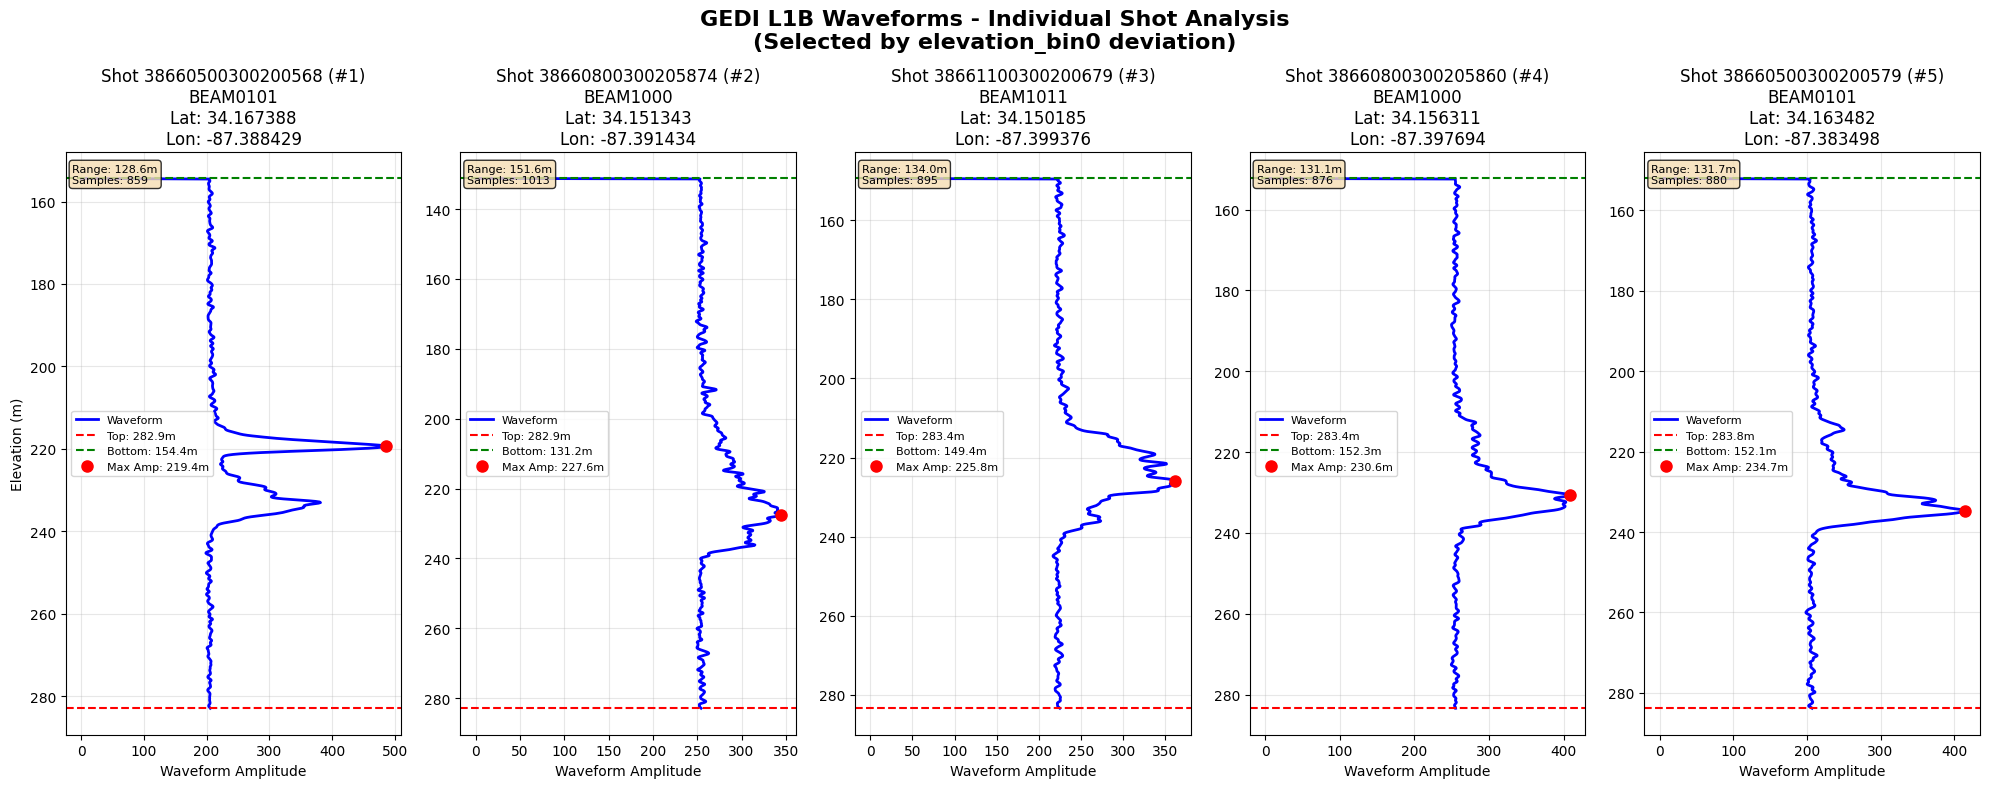


🗺️ Creating map with highlighted shots...

🗺️ Displaying map with highlighted shots...



📊 WAVEFORM ANALYSIS COMPLETE!
✅ 5 waveforms plotted based on elevation_bin0 selection
✅ Interactive map with highlighted shots created
✅ Individual shot locations and elevations displayed
✅ Waveform statistics and elevation markers shown

🔧 TO ANALYZE DIFFERENT SHOTS:
   Change 'user_sd_from_mean' value and re-run this code block
   Examples:
     user_sd_from_mean = 2.0   # Much higher elevations
     user_sd_from_mean = 0.0   # Average elevation shots
     user_sd_from_mean = -2.0  # Much lower elevations

📈 ELEVATION STATISTICS:
   Selected shots elevation range: 282.9 to 283.8 m
   Target elevation was: 283.1 m
   Actual mean of selected: 283.3 m

WAVEFORM VISUALIZATION COMPLETE
✅ Elevation_bin0 based shot selection
✅ 5 individual waveform plots with elevation markers
✅ Interactive map with elevation-colored shots


In [7]:
# GEDI L1B Waveform Visualization - Simplified Version
# Run this AFTER the main processing code block has completed successfully
# This code block uses elevation_bin0 for shot selection and waveform visualization

import numpy as np
import matplotlib.pyplot as plt
import folium
import h5py
import os

print(f"\n{'='*80}")
print("WAVEFORM VISUALIZATION MODULE - SIMPLIFIED")
print(f"{'='*80}")

def select_shots_by_elevation_deviation(result_df, sd_from_mean=1.2, n_shots=5):
    """
    Select shots based on standard deviations from mean elevation_bin0

    Parameters:
    result_df: DataFrame with shot data including elevation_bin0
    sd_from_mean: float, standard deviations from mean (positive or negative)
    n_shots: int, number of shots to select

    Returns:
    DataFrame with selected shots
    """

    mean_elevation = result_df['elevation_bin0'].mean()
    std_elevation = result_df['elevation_bin0'].std()
    target_elevation = mean_elevation + (sd_from_mean * std_elevation)

    print(f"🎯 Target selection parameters:")
    print(f"   Mean elevation_bin0: {mean_elevation:.2f} m")
    print(f"   Std elevation_bin0:  {std_elevation:.2f} m")
    print(f"   Target elevation_bin0: {target_elevation:.2f} m ({sd_from_mean:+.1f}σ)")

    # Calculate distance from target
    result_df_copy = result_df.copy()
    result_df_copy['elevation_distance'] = np.abs(result_df_copy['elevation_bin0'] - target_elevation)

    # Select the closest shots
    selected_shots = result_df_copy.nsmallest(n_shots, 'elevation_distance')

    print(f"📋 Selected {len(selected_shots)} shots:")
    for i, (_, row) in enumerate(selected_shots.iterrows()):
        print(f"   {i+1}. Shot {row['shot_number']}: elevation_bin0={row['elevation_bin0']:.2f}m, "
              f"Lat={row['latitude']:.6f}, Lon={row['longitude']:.6f}, Beam={row['beam']}")

    return selected_shots

def extract_and_plot_waveforms_simple(file_path, selected_shots):
    """
    Extract and plot waveforms for selected shots using elevation_bin0

    Parameters:
    file_path: str, path to GEDI L1B HDF5 file
    selected_shots: DataFrame with selected shot information
    """

    print(f"\n📊 Extracting waveforms from {os.path.basename(file_path)}...")

    waveform_data = []

    with h5py.File(file_path, 'r') as gedi_file:
        # Get the full waveform data for all Full Power beams
        rxwaveform_full = {}
        for beam in FULL_POWER_BEAMS:
            if beam in gedi_file:
                rxwaveform_full[beam] = gedi_file[f'{beam}/rxwaveform'][:]

        # Extract waveforms for each selected shot
        for i, (_, shot) in enumerate(selected_shots.iterrows()):
            beam = shot['beam']

            # We need to get all the required data from the HDF5 file
            # Find the shot in the original beam data
            shot_numbers = gedi_file[f'{beam}/shot_number'][:]
            shot_idx = np.where(shot_numbers == shot['shot_number'])[0]

            if len(shot_idx) == 0:
                print(f"   ⚠️ Shot {shot['shot_number']} not found in {beam}")
                continue

            shot_idx = shot_idx[0]

            # Get all the data we need from the file
            start_idx = gedi_file[f'{beam}/rx_sample_start_index'][shot_idx]
            sample_count = gedi_file[f'{beam}/rx_sample_count'][shot_idx]
            elevation_bin0 = gedi_file[f'{beam}/geolocation/elevation_bin0'][shot_idx]
            elevation_lastbin = gedi_file[f'{beam}/geolocation/elevation_lastbin'][shot_idx]

            if beam in rxwaveform_full and sample_count > 0:
                # Extract the waveform
                waveform = rxwaveform_full[beam][start_idx:start_idx + sample_count]

                # Create elevation array for this waveform
                elevations = np.linspace(elevation_bin0, elevation_lastbin, len(waveform))

                waveform_data.append({
                    'shot_number': shot['shot_number'],
                    'beam': beam,
                    'latitude': shot['latitude'],
                    'longitude': shot['longitude'],
                    'elevation_bin0': elevation_bin0,
                    'elevation_lastbin': elevation_lastbin,
                    'waveform': waveform,
                    'elevations': elevations,
                    'elevation_range': elevation_bin0 - elevation_lastbin,
                    'selection_rank': i + 1
                })

                print(f"   ✅ Extracted waveform for shot {shot['shot_number']} ({len(waveform)} samples)")
            else:
                print(f"   ⚠️ Could not extract waveform for shot {shot['shot_number']} in {beam}")

    if not waveform_data:
        print("❌ No waveforms could be extracted")
        return None

    print(f"✅ Extracted {len(waveform_data)} waveforms")

    # Create the waveform plots
    fig, axes = plt.subplots(1, len(waveform_data), figsize=(4*len(waveform_data), 8), sharey=False)

    if len(waveform_data) == 1:
        axes = [axes]

    for i, (ax, wf_data) in enumerate(zip(axes, waveform_data)):
        # Plot the waveform
        ax.plot(wf_data['waveform'], wf_data['elevations'], 'b-', linewidth=2, label='Waveform')

        # Mark the top of waveform (elevation_bin0)
        ax.axhline(y=wf_data['elevation_bin0'], color='red', linestyle='--',
                  label=f'Top: {wf_data["elevation_bin0"]:.1f}m')

        # Mark the bottom of waveform (elevation_lastbin)
        ax.axhline(y=wf_data['elevation_lastbin'], color='green', linestyle='--',
                  label=f'Bottom: {wf_data["elevation_lastbin"]:.1f}m')

        # Find and mark the maximum amplitude point
        max_amp_idx = np.argmax(wf_data['waveform'])
        max_amp_elevation = wf_data['elevations'][max_amp_idx]
        max_amp_value = wf_data['waveform'][max_amp_idx]
        ax.plot(max_amp_value, max_amp_elevation, 'ro', markersize=8,
               label=f'Max Amp: {max_amp_elevation:.1f}m')

        # Formatting
        ax.set_xlabel('Waveform Amplitude')
        if i == 0:
            ax.set_ylabel('Elevation (m)')

        ax.set_title(f"Shot {wf_data['shot_number']} (#{wf_data['selection_rank']})\n"
                    f"{wf_data['beam']}\n"
                    f"Lat: {wf_data['latitude']:.6f}\n"
                    f"Lon: {wf_data['longitude']:.6f}")

        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        ax.invert_yaxis()  # Higher elevations at top

        # Add some stats as text
        stats_text = f"Range: {wf_data['elevation_range']:.1f}m\nSamples: {len(wf_data['waveform'])}"
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', fontsize=8,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.suptitle('GEDI L1B Waveforms - Individual Shot Analysis\n(Selected by elevation_bin0 deviation)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return waveform_data

def create_highlighted_map_simple(result_df, selected_shots):
    """
    Create an interactive map highlighting the selected shots

    Parameters:
    result_df: DataFrame with all shot data
    selected_shots: DataFrame with selected shots to highlight
    """

    print(f"\n🗺️ Creating map with highlighted shots...")

    # Calculate map center
    center_lat = result_df['latitude'].mean()
    center_lon = result_df['longitude'].mean()

    # Create map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

    # Add AOI rectangle
    folium.Rectangle(
        bounds=[[aoi_bbox[1], aoi_bbox[0]], [aoi_bbox[3], aoi_bbox[2]]],
        fill=False,
        color='red',
        weight=3,
        popup='Area of Interest'
    ).add_to(m)

    # Color map for different beams
    beam_colors = {'BEAM0101': 'red', 'BEAM0110': 'blue', 'BEAM1000': 'green', 'BEAM1011': 'orange'}

    # Add all shots as small points colored by elevation_bin0
    min_elev = result_df['elevation_bin0'].min()
    max_elev = result_df['elevation_bin0'].max()

    for _, row in result_df.iterrows():
        # Color based on elevation (normalized to 0-1)
        elev_norm = (row['elevation_bin0'] - min_elev) / (max_elev - min_elev) if max_elev > min_elev else 0.5

        # Use a color scale from blue (low) to red (high)
        if elev_norm < 0.33:
            color = 'blue'
        elif elev_norm < 0.67:
            color = 'green'
        else:
            color = 'red'

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=2,
            popup=f"Beam: {row['beam']}<br>"
                  f"Shot: {row['shot_number']}<br>"
                  f"Elevation: {row['elevation_bin0']:.1f}m",
            color=color,
            fillColor=color,
            fillOpacity=0.4,
            weight=1
        ).add_to(m)

    # Highlight selected shots with large, distinctive markers
    for i, (_, shot) in enumerate(selected_shots.iterrows()):
        # Large highlighted marker
        folium.CircleMarker(
            location=[shot['latitude'], shot['longitude']],
            radius=15,
            popup=f"<b>SELECTED SHOT {i+1}</b><br>"
                  f"Beam: {shot['beam']}<br>"
                  f"Shot: {shot['shot_number']}<br>"
                  f"Elevation_bin0: {shot['elevation_bin0']:.2f}m<br>"
                  f"Lat: {shot['latitude']:.6f}<br>"
                  f"Lon: {shot['longitude']:.6f}",
            color='black',
            fillColor='yellow',
            fillOpacity=0.9,
            weight=4
        ).add_to(m)

        # Add number label
        folium.Marker(
            location=[shot['latitude'], shot['longitude']],
            popup=f"Selected Shot {i+1}",
            icon=folium.DivIcon(
                html=f"<div style='font-size: 14pt; font-weight: bold; color: black; "
                     f"text-align: center; background-color: white; border-radius: 50%; "
                     f"width: 25px; height: 25px; line-height: 25px;'>{i+1}</div>",
                icon_size=(25, 25),
                icon_anchor=(12, 12)
            )
        ).add_to(m)

    # Add legend
    legend_html = f'''
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 220px; height: 180px;
                background-color: white; border:2px solid grey; z-index:9999;
                font-size:12px; padding: 10px">
    <p><b>GEDI L1B Shots</b></p>
    <p><b>Elevation Color Scale:</b></p>
    <p><i class="fa fa-circle" style="color:blue"></i> Low ({min_elev:.0f}m)</p>
    <p><i class="fa fa-circle" style="color:green"></i> Medium</p>
    <p><i class="fa fa-circle" style="color:red"></i> High ({max_elev:.0f}m)</p>
    <p><b>🟡 Selected for Waveform Analysis</b></p>
    <p><b>🔴 AOI Boundary</b></p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

# USER INTERFACE: Simplified Waveform Analysis
# Check if we have the required data from the main processing block
if 'result_df' in locals() and result_df is not None and 'final_file' in locals() and final_file is not None:
    print(f"\n🎯 WAVEFORM ANALYSIS READY!")
    print(f"Data available: {len(result_df)} high-quality shots")
    print(f"Elevation_bin0 range: {result_df['elevation_bin0'].min():.1f} to {result_df['elevation_bin0'].max():.1f} m")
    print(f"Mean elevation_bin0: {result_df['elevation_bin0'].mean():.2f} ± {result_df['elevation_bin0'].std():.2f} m")

    # USER CONFIGURATION: Set your desired standard deviation
    # Examples:
    #   1.2  = 1.2 standard deviations ABOVE mean (higher elevations)
    #   0.0  = closest to mean (average elevations)
    #  -1.5  = 1.5 standard deviations BELOW mean (lower elevations)

    user_sd_from_mean = 1.2  # 🔧 CHANGE THIS VALUE

    print(f"\n🔧 USER CONFIGURATION:")
    print(f"   Standard deviations from mean: {user_sd_from_mean:+.1f}")
    target_elev = result_df['elevation_bin0'].mean() + user_sd_from_mean * result_df['elevation_bin0'].std()
    print(f"   This will select shots with elevation_bin0 ≈ {target_elev:.1f} m")

    # Select shots based on user criteria
    selected_shots = select_shots_by_elevation_deviation(
        result_df,
        sd_from_mean=user_sd_from_mean,
        n_shots=5
    )

    # Extract and plot waveforms
    waveform_data = extract_and_plot_waveforms_simple(final_file, selected_shots)

    # Create highlighted map
    if waveform_data:
        highlighted_map = create_highlighted_map_simple(result_df, selected_shots)
        print(f"\n🗺️ Displaying map with highlighted shots...")
        display(highlighted_map)  # Use display() for better rendering in notebooks

    print(f"\n📊 WAVEFORM ANALYSIS COMPLETE!")
    print(f"✅ 5 waveforms plotted based on elevation_bin0 selection")
    print(f"✅ Interactive map with highlighted shots created")
    print(f"✅ Individual shot locations and elevations displayed")
    print(f"✅ Waveform statistics and elevation markers shown")

    print(f"\n🔧 TO ANALYZE DIFFERENT SHOTS:")
    print(f"   Change 'user_sd_from_mean' value and re-run this code block")
    print(f"   Examples:")
    print(f"     user_sd_from_mean = 2.0   # Much higher elevations")
    print(f"     user_sd_from_mean = 0.0   # Average elevation shots")
    print(f"     user_sd_from_mean = -2.0  # Much lower elevations")

    print(f"\n📈 ELEVATION STATISTICS:")
    print(f"   Selected shots elevation range: {selected_shots['elevation_bin0'].min():.1f} to {selected_shots['elevation_bin0'].max():.1f} m")
    print(f"   Target elevation was: {target_elev:.1f} m")
    print(f"   Actual mean of selected: {selected_shots['elevation_bin0'].mean():.1f} m")

else:
    print(f"\n❌ No data available for waveform analysis")
    print(f"   Please run the main data processing code block first")
    print(f"   Required variables: 'result_df' and 'final_file'")

    # Check what variables are available
    if 'CURRENT_RESULT_DF' in locals() and CURRENT_RESULT_DF is not None:
        print(f"\n💡 Found 'CURRENT_RESULT_DF' - using this instead...")
        result_df = CURRENT_RESULT_DF
        if 'CURRENT_FILE' in locals():
            final_file = CURRENT_FILE
            print(f"   Also found 'CURRENT_FILE' - ready to proceed!")
            # You can now re-run the analysis section above
        else:
            print(f"   But 'CURRENT_FILE' not found - cannot extract waveforms")
    else:
        print(f"   Available variables: {[var for var in locals().keys() if not var.startswith('_')]}")

print(f"\n{'='*80}")
print("WAVEFORM VISUALIZATION COMPLETE")
print(f"{'='*80}")
print("✅ Elevation_bin0 based shot selection")
print("✅ 5 individual waveform plots with elevation markers")
print("✅ Interactive map with elevation-colored shots")